In [81]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os

In [82]:
SCRIPT_DIR = os.getcwd()
datasets_path = os.path.join(SCRIPT_DIR,os.pardir, "an2dl2526c2")
DATASET_PATH = os.path.join(datasets_path, "train_data")

# Usage Example
img_path = os.path.join(DATASET_PATH, "img_0000.png")
mask_path = os.path.join(DATASET_PATH, "mask_0000.png")

In [83]:
def extract_masked_patches(img_path, mask_path, patch_size=224, overlap=-0.15, threshold=0.5):
    """
    Extracts patches from the image only where the mask is active.
    """
    # Load images
    # We use try/except to handle potential extension mismatches (png vs jpg)
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        # Fallback for common extension swap if .png not found
        if img_path.endswith(".png"):
            img = Image.open(img_path.replace(".png", ".jpg")).convert("RGB")
        else:
            raise

    mask = Image.open(mask_path).convert("L") # Grayscale
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # --- Robust Mask Normalization ---
    # Some masks are binary (0, 1), others are (0, 255). 
    # If max value is 1, we treat 1 as "active".
    # We create a temporary normalized mask for threshold checking.
    if mask_arr.max() <= 1:
        # Convert 0/1 to 0/255 for consistent logic
        mask_check = mask_arr * 255
    else:
        mask_check = mask_arr
    
    h, w, _ = img_arr.shape
    patches = []
    coords = []
    
    # Step size (stride)
    step = int(patch_size * (1 - overlap))
    
    # Sliding window
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            # Extract mask patch
            mask_patch = mask_check[y:y+patch_size, x:x+patch_size]
            
            # Check if patch is "interesting" (active area > 128 intensity)
            if (np.sum(mask_patch > 128) / (patch_size**2)) >= threshold:
                
                # If valid, crop the actual tissue image
                img_patch = img_arr[y:y+patch_size, x:x+patch_size]
                patches.append(img_patch)
                coords.append((x, y))
                
    return patches, coords, img_arr, mask_arr

In [84]:
# threshold=0.001 means at least 0.1% of the patch must be in the mask region
# We now receive the mask_arr as the 4th return value
valid_patches, valid_coords, full_img_arr, full_mask_arr = extract_masked_patches(img_path, mask_path, threshold=0.001)

print(f"Extracted {len(valid_patches)} valid tumor patches from biopsy.")


Extracted 7 valid tumor patches from biopsy.


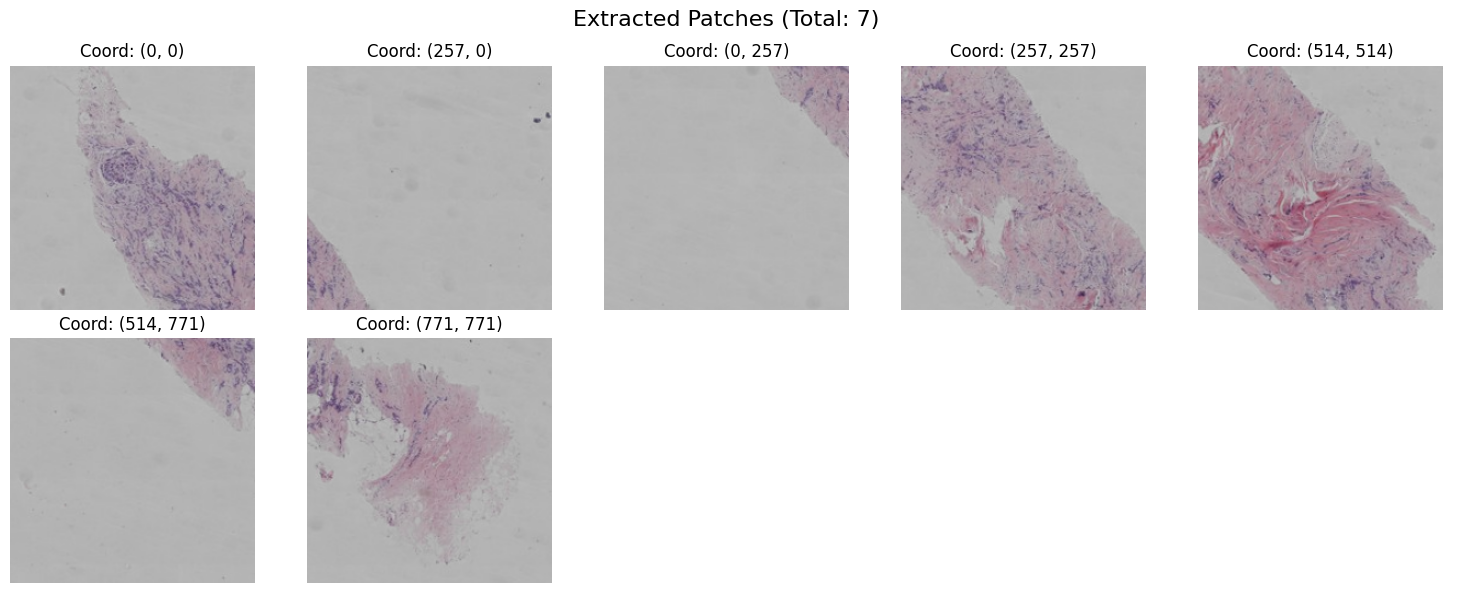

In [85]:
# --- Visualization 1: Plot All Patches (Grid) ---
if len(valid_patches) > 0:
    # Determine grid size (approx square)
    n_patches = len(valid_patches)
    cols = 5
    rows = math.ceil(n_patches / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(f"Extracted Patches (Total: {n_patches})", fontsize=16)
    
    # Flatten axes for easy iteration if it's a grid, handle single row/col cases
    if n_patches == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_patches:
            ax.imshow(valid_patches[i])
            ax.set_title(f"Coord: {valid_coords[i]}")
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots
            
    plt.tight_layout()
    plt.show()

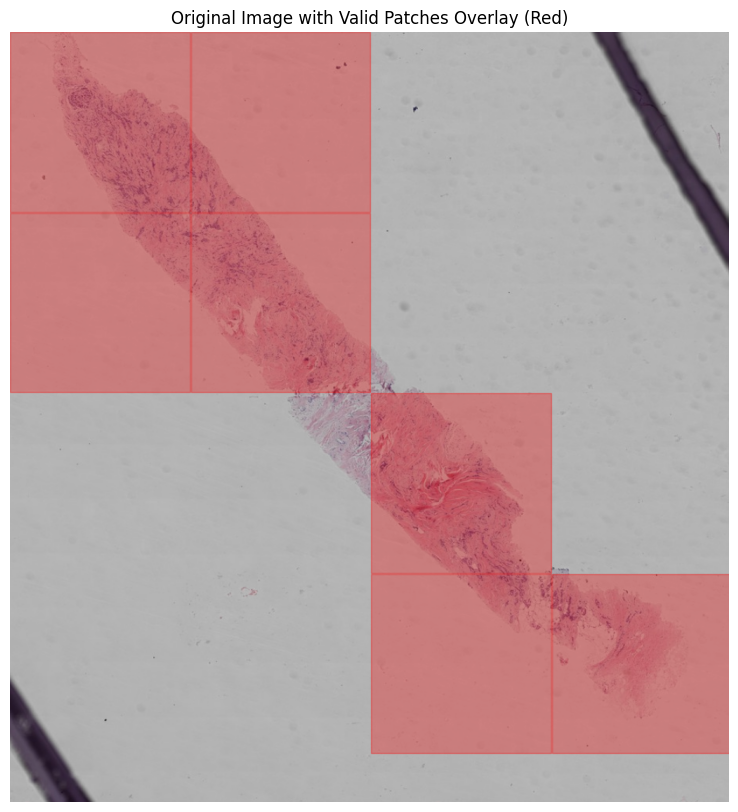

In [86]:
# --- Visualization 2: Overlay on Original Image ---
if len(valid_patches) > 0:
    plt.figure(figsize=(10, 10))
    plt.imshow(full_img_arr)
    ax = plt.gca()
    
    # Patch size assumed from logic above (re-deriving or hardcoding 256)
    patch_size = 256
    
    for (x, y) in valid_coords:
        # Create a red rectangle with alpha=0.3
        rect = mpatches.Rectangle(
            (x, y), patch_size, patch_size, 
            linewidth=1, edgecolor='red', facecolor='red', alpha=0.3
        )
        ax.add_patch(rect)
        
    plt.title("Original Image with Valid Patches Overlay (Red)")
    plt.axis('off')
    plt.show()
else:
    print("No valid patches found to visualize.")

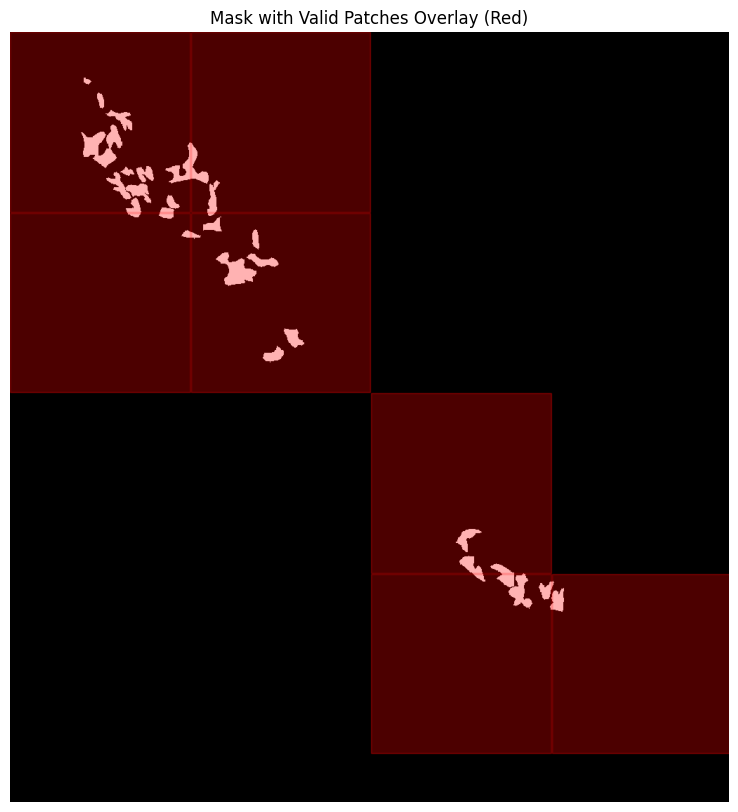

In [87]:
# --- Visualization 3: Overlay on Mask ---
if len(valid_patches) > 0:
    plt.figure(figsize=(10, 10))
    # Display mask in grayscale
    plt.imshow(full_mask_arr, cmap='gray')
    ax = plt.gca()
    
    patch_size = 256
    
    for (x, y) in valid_coords:
        # Create a red rectangle with alpha=0.3
        # Using a slightly different color or alpha if needed to contrast with black/white mask
        rect = mpatches.Rectangle(
            (x, y), patch_size, patch_size, 
            linewidth=1, edgecolor='red', facecolor='red', alpha=0.3
        )
        ax.add_patch(rect)
        
    plt.title("Mask with Valid Patches Overlay (Red)")
    plt.axis('off')
    plt.show()
else:
    print("No valid patches found to visualize.")